Epoch 1: Train Acc = 45.10%, Test Acc = 44.83%, Avg Loss = 2.0650
Epoch 2: Train Acc = 54.44%, Test Acc = 53.76%, Avg Loss = 1.8980
Epoch 3: Train Acc = 39.64%, Test Acc = 39.31%, Avg Loss = 1.8666
Epoch 4: Train Acc = 64.83%, Test Acc = 63.44%, Avg Loss = 1.8233
Epoch 5: Train Acc = 64.24%, Test Acc = 62.92%, Avg Loss = 1.7807
Epoch 6: Train Acc = 65.30%, Test Acc = 64.07%, Avg Loss = 1.7521
Epoch 7: Train Acc = 64.66%, Test Acc = 63.67%, Avg Loss = 1.7151
Epoch 8: Train Acc = 66.14%, Test Acc = 64.79%, Avg Loss = 1.7040
Epoch 9: Train Acc = 74.89%, Test Acc = 73.96%, Avg Loss = 1.6856
Epoch 10: Train Acc = 72.10%, Test Acc = 70.40%, Avg Loss = 1.6756
Epoch 11: Train Acc = 76.48%, Test Acc = 74.87%, Avg Loss = 1.6603
Epoch 12: Train Acc = 76.80%, Test Acc = 75.57%, Avg Loss = 1.6463
Epoch 13: Train Acc = 74.41%, Test Acc = 73.40%, Avg Loss = 1.6495
Epoch 14: Train Acc = 78.75%, Test Acc = 77.34%, Avg Loss = 1.6216
Epoch 15: Train Acc = 74.96%, Test Acc = 73.21%, Avg Loss = 1.6165
Epoc

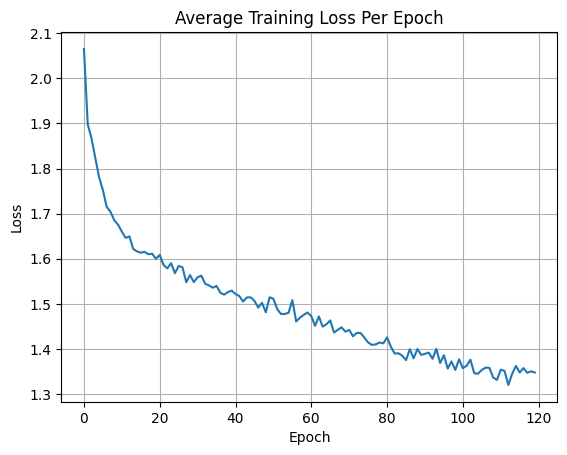

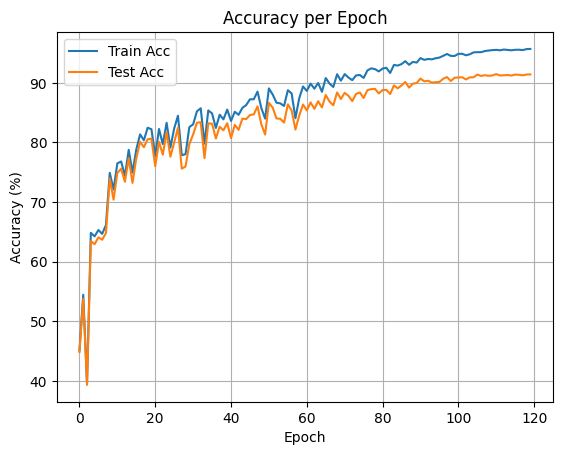


Highest Test Accuracy Achieved: 91.46%


In [ ]:
# CIFAR-10 Optimized CNN with CutMix, Label Smoothing, DropBlock, Cosine LR

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# --- SETTINGS ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
BATCH_SIZE = 128  # Batch size for training and testing
EPOCHS = 120  # Maximum number of training epochs
PATIENCE = 15  # Early stopping patience

# --- CUTMIX FUNCTION ---
def rand_bbox(size, lam):
    # Generate random bounding box for CutMix
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0):
    # Apply CutMix augmentation
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0]).to(device)
    y_a = y
    y_b = y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    # Combine losses using CutMix lambda value
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- LABEL SMOOTHING LOSS ---
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=10, smoothing=0.1):
        # Initialize label smoothing
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, target):
        # Apply smoothed label distribution
        pred = self.log_softmax(x)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=1))

# --- DROPBLOCK ---
class DropBlock2D(nn.Module):
    def __init__(self, block_size=3, drop_prob=0.1):
        # Initialize DropBlock
        super().__init__()
        self.block_size = block_size
        self.drop_prob = drop_prob

    def forward(self, x):
        # Apply DropBlock during training only
        if not self.training or self.drop_prob == 0.:
            return x
        gamma = self.drop_prob / (self.block_size ** 2)
        for s in x.shape[2:]:
            gamma *= s / (s - self.block_size + 1)
        mask = (torch.rand(x.shape[0], 1, *x.shape[2:], device=x.device) < gamma).float()
        mask = F.max_pool2d(mask, self.block_size, stride=1, padding=self.block_size // 2)
        mask = 1 - mask
        return x * mask * (mask.numel() / mask.sum())

# --- MODEL BLOCKS ---
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        # Block with two conv layers + DropBlock
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            DropBlock2D(block_size=3, drop_prob=0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        # Output block with GAP, FC layer and dropout
        super().__init__()
        self.fc1 = nn.Linear(in_channels, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.mean(dim=(2, 3))  # Global Average Pooling
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

class CustomCNN(nn.Module):
    def __init__(self):
        # Full CNN model using intermediate blocks and output block
        super().__init__()
        self.block1 = IntermediateBlock(3, 64)
        self.block2 = IntermediateBlock(64, 128)
        self.block3 = IntermediateBlock(128, 256)
        self.pool = nn.MaxPool2d(2, 2)
        self.output = OutputBlock(256, 10)

    def forward(self, x):
        x = self.pool(self.block1(x))
        x = self.pool(self.block2(x))
        x = self.pool(self.block3(x))
        return self.output(x)

# --- ACCURACY ---
def accuracy(outputs, labels):
    # Calculate total correct predictions
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()

# --- INITIALIZER ---
def init_weights(m):
    # Apply Xavier initialization to conv and linear layers
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# --- DATASETS ---
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation: random crop
    transforms.RandomHorizontalFlip(),     # Data augmentation: horizontal flip
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Only tensor conversion
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize
])

# Load CIFAR-10 train/test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

trainset_eval = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_test)
trainloader_eval = torch.utils.data.DataLoader(trainset_eval, batch_size=BATCH_SIZE, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# --- TRAINING ---
def train_model(model):
    model.to(device)  # Move model to GPU if available
    model.apply(init_weights)  # Apply Xavier initialization
    criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)  # Use smoothed cross entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)  # Cosine LR

    best_acc = 0
    train_losses, train_accs, test_accs = [], [], []
    early_counter = 0  # For early stopping

    for epoch in range(EPOCHS):
        model.train()  # Enable training mode
        total_loss = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, y_a, y_b, lam = cutmix_data(inputs, labels)  # Apply CutMix
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cutmix_criterion(criterion, outputs, y_a, y_b, lam)  # CutMix loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(trainloader))  # Average training loss

        # Evaluate on non-augmented training set
        model.eval()
        correct_train = 0
        total_train = 0
        with torch.no_grad():
            for inputs, labels in trainloader_eval:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                correct_train += accuracy(outputs, labels)
                total_train += labels.size(0)
        train_acc = 100.0 * correct_train / total_train
        train_accs.append(train_acc)

        # Evaluate on test set
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                correct += accuracy(outputs, labels)
                total += labels.size(0)
        test_acc = 100.0 * correct / total
        test_accs.append(test_acc)

        # Print stats
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Test Acc = {test_acc:.2f}%, Avg Loss = {train_losses[-1]:.4f}")

        # Early stopping check
        if test_acc > best_acc:
            best_acc = test_acc
            early_counter = 0
        else:
            early_counter += 1
            if early_counter >= PATIENCE:
                print("Early stopping...")
                break

        scheduler.step()  # Update LR

    return train_losses, train_accs, test_accs, best_acc

# --- RUN ---
model = CustomCNN()  # Initialize model
train_losses, train_accs, test_accs, best_acc = train_model(model)  # Train the model

# --- PLOTS ---
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss Per Epoch')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.grid(True)
plt.show()

print(f"\nHighest Test Accuracy Achieved: {best_acc:.2f}%")

In [ ]:
print(f"Best Test Accuracy Achieved: {max(test_accs):.2f}%")
best_epoch = test_accs.index(max(test_accs)) + 1
print(f"Achieved at Epoch: {best_epoch}")

Best Test Accuracy Achieved: 91.46%
Achieved at Epoch: 111
